#Importing Libraries 

In [1]:
print("hello")

hello


In [2]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim



#Configuration

In [13]:
training_path = "C:/Users/Deekshith Sanem/Downloads/apppu/DIV2K_train_HR/DIV2K_train_HR"
validation_path= "C:/Users/Deekshith Sanem/Downloads/apppu/DIV2K_valid_HR/DIV2K_valid_HR"
image_dimension = 128
scaling_factor =2
batch_size = 8
number_of_epochs = 70
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
print(device)

cuda


#D
ataset Class 

In [15]:
class SuperResolutionDataset(Dataset):
    def __init__(self, directory_path):
        self.file_list = sorted([
            os.path.join(directory_path, file_name) for file_name in os.listdir(directory_path)
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        print(f"Found {len(self.file_list)} images in {directory_path}")

        self.high_res_transform = transforms.Compose([
            transforms.CenterCrop(image_dimension),
            transforms.ToTensor()
        ])
        self.low_res_transform = transforms.Compose([
            transforms.CenterCrop(image_dimension),
            transforms.Resize(image_dimension // scaling_factor, interpolation=Image.BICUBIC),
            transforms.Resize(image_dimension, interpolation=Image.BICUBIC),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        image = Image.open(self.file_list[index]).convert("RGB")
        high_res = self.high_res_transform(image)
        low_res = self.low_res_transform(image)
        return low_res, high_res, os.path.basename(self.file_list[index])


#Load Datasets and Dataloaders

In [16]:
training_dataset = SuperResolutionDataset(training_path)
validation_dataset = SuperResolutionDataset(validation_path)

training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


Found 800 images in C:/Users/Deekshith Sanem/Downloads/apppu/DIV2K_train_HR/DIV2K_train_HR
Found 100 images in C:/Users/Deekshith Sanem/Downloads/apppu/DIV2K_valid_HR/DIV2K_valid_HR


#Defining the Model 

In [17]:
class SuperResolutionCNN(nn.Module):
    def __init__(self):
        super(SuperResolutionCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, padding=2)
        )

    def forward(self, input_image):
        return self.network(input_image)


#Model Initialization

In [18]:
model = SuperResolutionCNN().to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


#Evaluating the Model

In [19]:
def super_resolution_model_performance(model_instance, data_loader, display_logs=True):
    model_instance.eval()
    cumulative_loss = 0
    total_psnr = 0
    total_ssim = 0
    loss_fn = nn.MSELoss()

    with torch.no_grad():
        for low_res, high_res, _ in data_loader:
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            output = model_instance(low_res)
            loss = loss_fn(output, high_res)
            cumulative_loss += loss.item()

            output_np = output.cpu().numpy()
            high_res_np = high_res.cpu().numpy()

            for i in range(output_np.shape[0]):
                output_img = np.transpose(output_np[i], (1, 2, 0))
                high_res_img = np.transpose(high_res_np[i], (1, 2, 0))
                total_psnr += compare_psnr(high_res_img, output_img, data_range=1.0)
                total_ssim += compare_ssim(high_res_img, output_img, data_range=1.0, win_size=7, channel_axis=-1)

    total_images = len(data_loader.dataset)
    avg_loss = cumulative_loss / len(data_loader)
    avg_psnr = total_psnr / total_images
    avg_ssim = total_ssim / total_images

    if display_logs:
        print(f"Validation Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

    return avg_loss, avg_psnr, avg_ssim

#Training the Model

In [20]:
def train_super_resolution_model(model_instance, training_loader, loss_function, optimizer_instance, validation_loader):
    model_instance.train()
    os.makedirs("checkpoints", exist_ok=True)

    training_loss_list = []
    validation_loss_list = []
    psnr_list = []
    ssim_list = []

    for epoch in range(number_of_epochs):
        start_time = time.time()
        epoch_loss = 0
        model_instance.train()

        for low_res, high_res, _ in training_loader:
            low_res = low_res.to(device)
            high_res = high_res.to(device)

            optimizer_instance.zero_grad()
            output = model_instance(low_res)
            loss = loss_function(output, high_res)
            loss.backward()
            optimizer_instance.step()

            epoch_loss += loss.item()

        val_loss, avg_psnr, avg_ssim = super_resolution_model_performance(model_instance, validation_loader, display_logs=False)
        epoch_duration = time.time() - start_time

        training_loss_list.append(epoch_loss / len(training_loader))
        validation_loss_list.append(val_loss)
        psnr_list.append(avg_psnr)
        ssim_list.append(avg_ssim)

        print(f"Epoch [{epoch + 1}/{number_of_epochs}] "
              f"| Time: {epoch_duration:.2f}s "
              f"| Train Loss: {training_loss_list[-1]:.4f} "
              f"| Val Loss: {val_loss:.4f} "
              f"| PSNR: {avg_psnr:.2f} "
              f"| SSIM: {avg_ssim:.4f}")

        if (epoch + 1) % 5 == 0:
            checkpoint_file = f"checkpoints/super_res_epoch_{epoch + 1}.pth"
            torch.save(model_instance.state_dict(), checkpoint_file)
            print(f"Checkpoint saved: {checkpoint_file}")

    return training_loss_list, validation_loss_list, psnr_list, ssim_list


#Run the Training 

In [21]:
training_loss_list, validation_loss_list, psnr_list, ssim_list = train_super_resolution_model(
    model_instance=model,
    training_loader=training_loader,
    loss_function=loss_function,
    optimizer_instance=optimizer,
    validation_loader=validation_loader
)


Epoch [1/70] | Time: 68.84s | Train Loss: 0.0396 | Val Loss: 0.0084 | PSNR: 21.96 | SSIM: 0.6917
Epoch [2/70] | Time: 58.35s | Train Loss: 0.0059 | Val Loss: 0.0042 | PSNR: 25.34 | SSIM: 0.7847
Epoch [3/70] | Time: 59.53s | Train Loss: 0.0038 | Val Loss: 0.0035 | PSNR: 26.37 | SSIM: 0.8172
Epoch [4/70] | Time: 59.13s | Train Loss: 0.0033 | Val Loss: 0.0030 | PSNR: 27.43 | SSIM: 0.8338
Epoch [5/70] | Time: 58.90s | Train Loss: 0.0030 | Val Loss: 0.0028 | PSNR: 27.80 | SSIM: 0.8446
Checkpoint saved: checkpoints/super_res_epoch_5.pth
Epoch [6/70] | Time: 60.06s | Train Loss: 0.0028 | Val Loss: 0.0027 | PSNR: 27.91 | SSIM: 0.8529
Epoch [7/70] | Time: 59.42s | Train Loss: 0.0027 | Val Loss: 0.0026 | PSNR: 28.08 | SSIM: 0.8581
Epoch [8/70] | Time: 60.29s | Train Loss: 0.0026 | Val Loss: 0.0025 | PSNR: 28.17 | SSIM: 0.8626
Epoch [9/70] | Time: 60.03s | Train Loss: 0.0027 | Val Loss: 0.0024 | PSNR: 28.58 | SSIM: 0.8655
Epoch [10/70] | Time: 59.76s | Train Loss: 0.0024 | Val Loss: 0.0024 | PSNR

In [24]:
import os
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)

print("Preparing metric values for plotting...")

epochs = len(training_loss_list)
epochs_range = range(1, epochs + 1)

psnr_deltas = [j - i for i, j in zip(psnr_list[:-1], psnr_list[1:])]
ssim_deltas = [j - i for i, j in zip(ssim_list[:-1], ssim_list[1:])]
loss_gaps = [v - t for t, v in zip(training_loss_list, validation_loss_list)]


Preparing metric values for plotting...


Plot — Loss (Train vs Val)


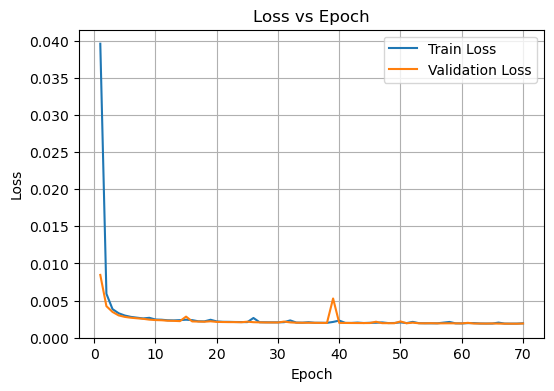

In [25]:
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, training_loss_list, label='Train Loss')
plt.plot(epochs_range, validation_loss_list, label='Validation Loss')
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("results/loss_plot.png")
plt.show()


Plot — PSNR and SSIM

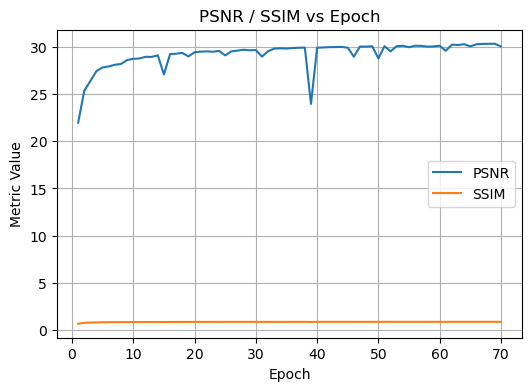

In [26]:
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, psnr_list, label='PSNR')
plt.plot(epochs_range, ssim_list, label='SSIM')
plt.legend()
plt.title("PSNR / SSIM vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.grid(True)
plt.savefig("results/psnr_ssim_plot.png")
plt.show()


Plot — Delta Metrics (Improvement per Epoch)

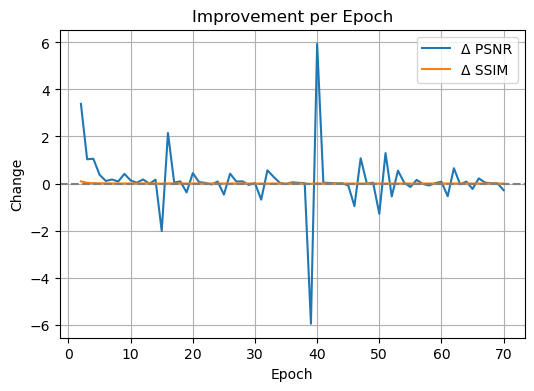

In [27]:
plt.figure(figsize=(6, 4))
plt.plot(epochs_range[1:], psnr_deltas, label='Δ PSNR')
plt.plot(epochs_range[1:], ssim_deltas, label='Δ SSIM')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.title("Improvement per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Change")
plt.grid(True)
plt.savefig("results/delta_metrics_plot.png")
plt.show()


Plot — Loss Gap (Overfitting Indicator)

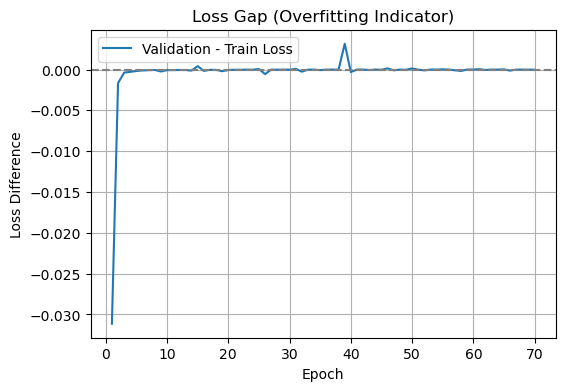

In [28]:
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, loss_gaps, label='Validation - Train Loss')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.title("Loss Gap (Overfitting Indicator)")
plt.xlabel("Epoch")
plt.ylabel("Loss Difference")
plt.grid(True)
plt.savefig("results/loss_gap_plot.png")
plt.show()


In [29]:
def super_resolution_visualization(model_instance, dataset_sample, num_images=5):
    model_instance.eval()
    os.makedirs("results/comparisons", exist_ok=True)

    for i in range(num_images):
        low_res, high_res, filename = dataset_sample[i]
        low_res = low_res.unsqueeze(0).to(device)

        with torch.no_grad():
            predicted = model_instance(low_res).cpu().squeeze(0)

        # Convert to PIL images
        low_res_img = transforms.ToPILImage()(low_res.squeeze(0).cpu().clamp(0, 1))
        high_res_img = transforms.ToPILImage()(high_res.clamp(0, 1))
        predicted_img = transforms.ToPILImage()(predicted.clamp(0, 1))

        # Bicubic interpolation for comparison
        bicubic_img = low_res_img.resize((high_res_img.width, high_res_img.height), Image.BICUBIC)

        # Metrics
        psnr_bicubic = compare_psnr(np.array(high_res_img), np.array(bicubic_img))
        ssim_bicubic = compare_ssim(np.array(high_res_img), np.array(bicubic_img), channel_axis=-1)

        psnr_predicted = compare_psnr(np.array(high_res_img), np.array(predicted_img))
        ssim_predicted = compare_ssim(np.array(high_res_img), np.array(predicted_img), channel_axis=-1)

        # Plotting
        fig, axs = plt.subplots(1, 4, figsize=(22, 6))

        axs[0].imshow(low_res_img)
        axs[0].set_title("Low-Res", fontsize=12)
        axs[0].axis("off")

        axs[1].imshow(bicubic_img)
        axs[1].set_title(f"Bicubic\nPSNR: {psnr_bicubic:.2f}, SSIM: {ssim_bicubic:.4f}", fontsize=12)
        axs[1].axis("off")

        axs[2].imshow(predicted_img)
        axs[2].set_title(f"SR Output\nPSNR: {psnr_predicted:.2f}, SSIM: {ssim_predicted:.4f}", fontsize=12)
        axs[2].axis("off")

        axs[3].imshow(high_res_img)
        axs[3].set_title("Ground Truth", fontsize=12)
        axs[3].axis("off")

        plt.figtext(0.5, 0.01, f"Filename: {filename}", ha="center", fontsize=11)
        plt.tight_layout(rect=[0, 0.03, 1, 1])
        plt.savefig(f"results/comparisons/{filename}")
        plt.show()

#Calling the Function

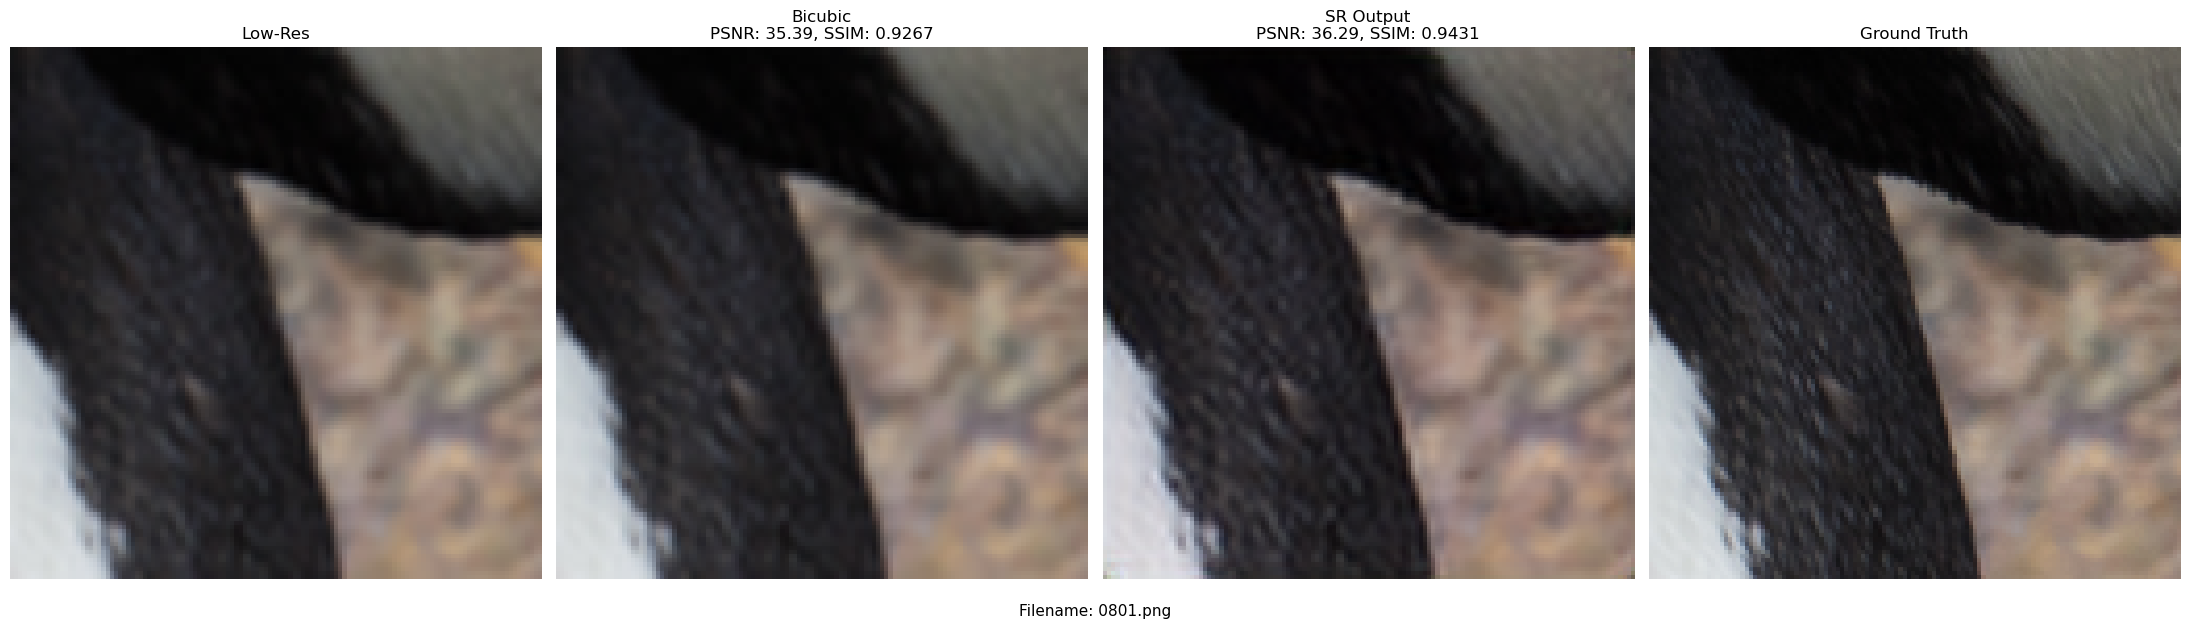

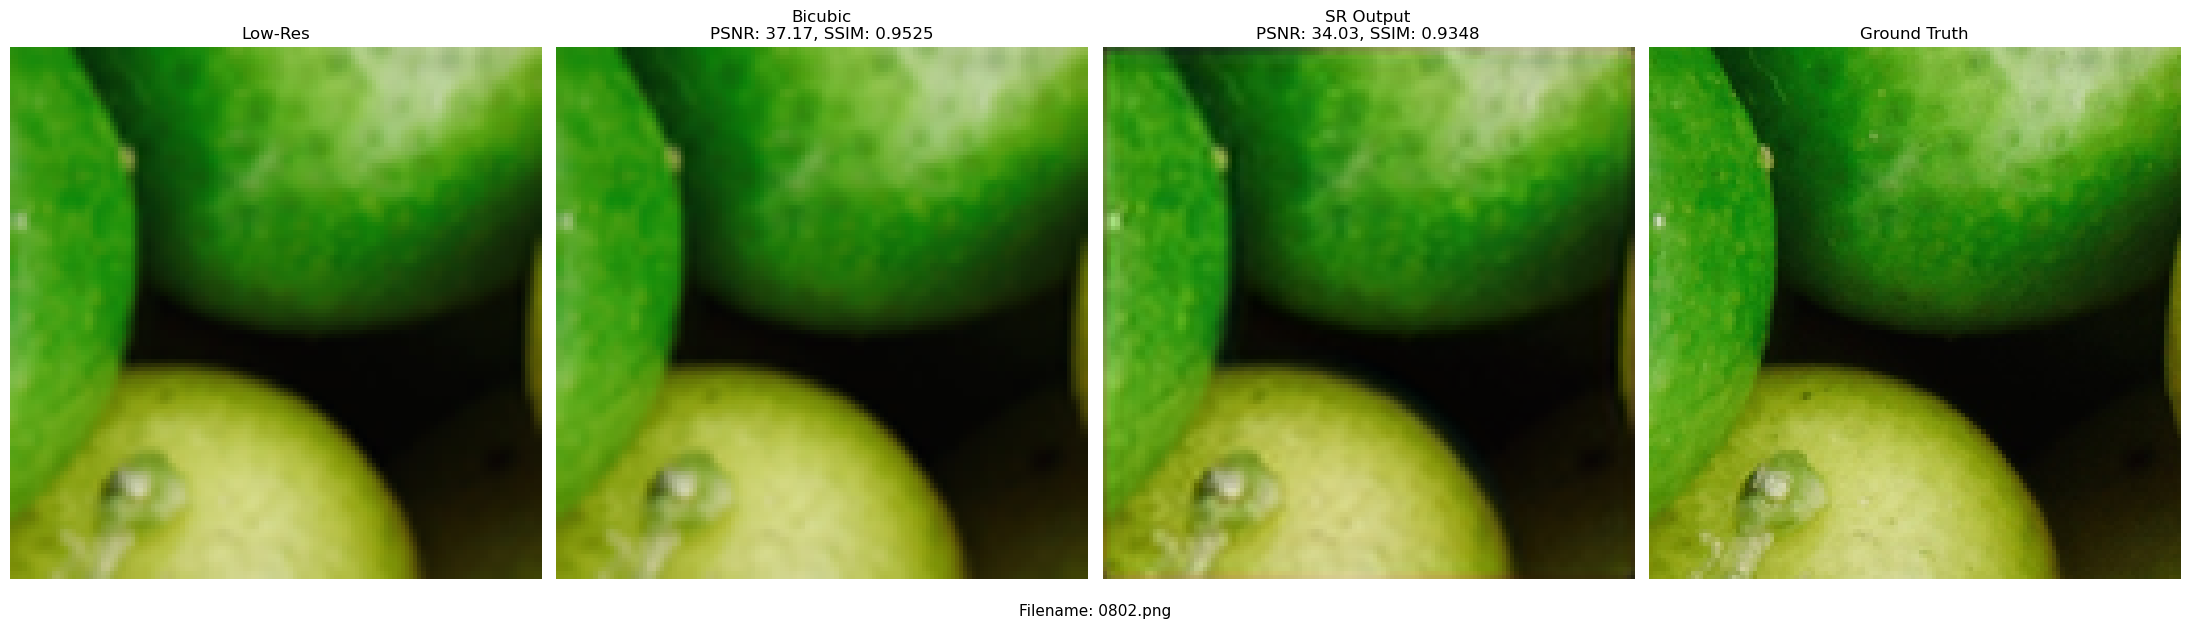

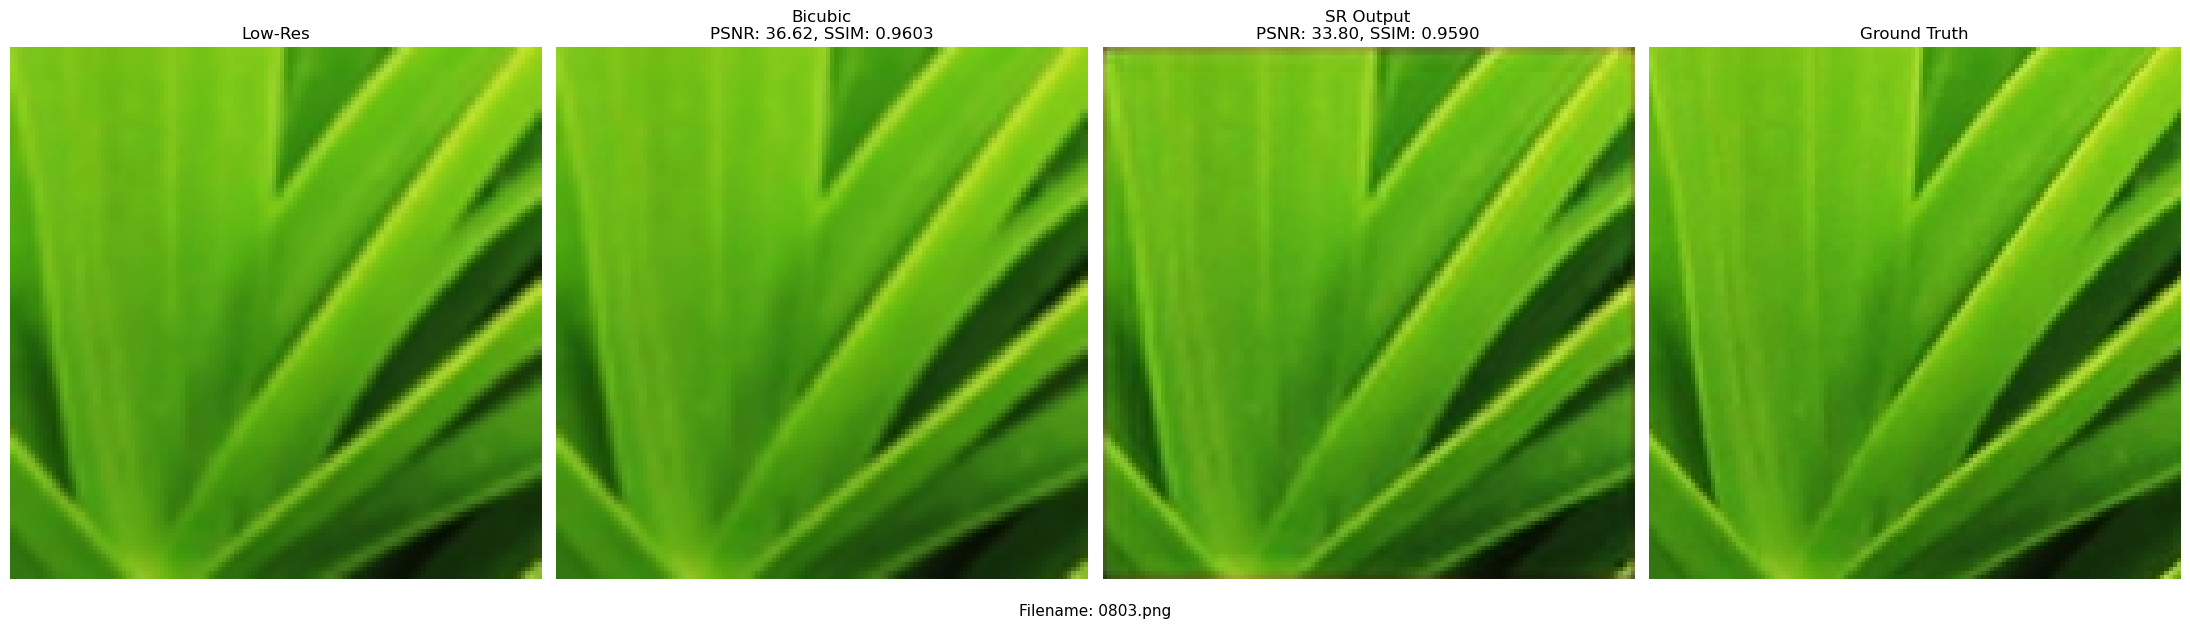

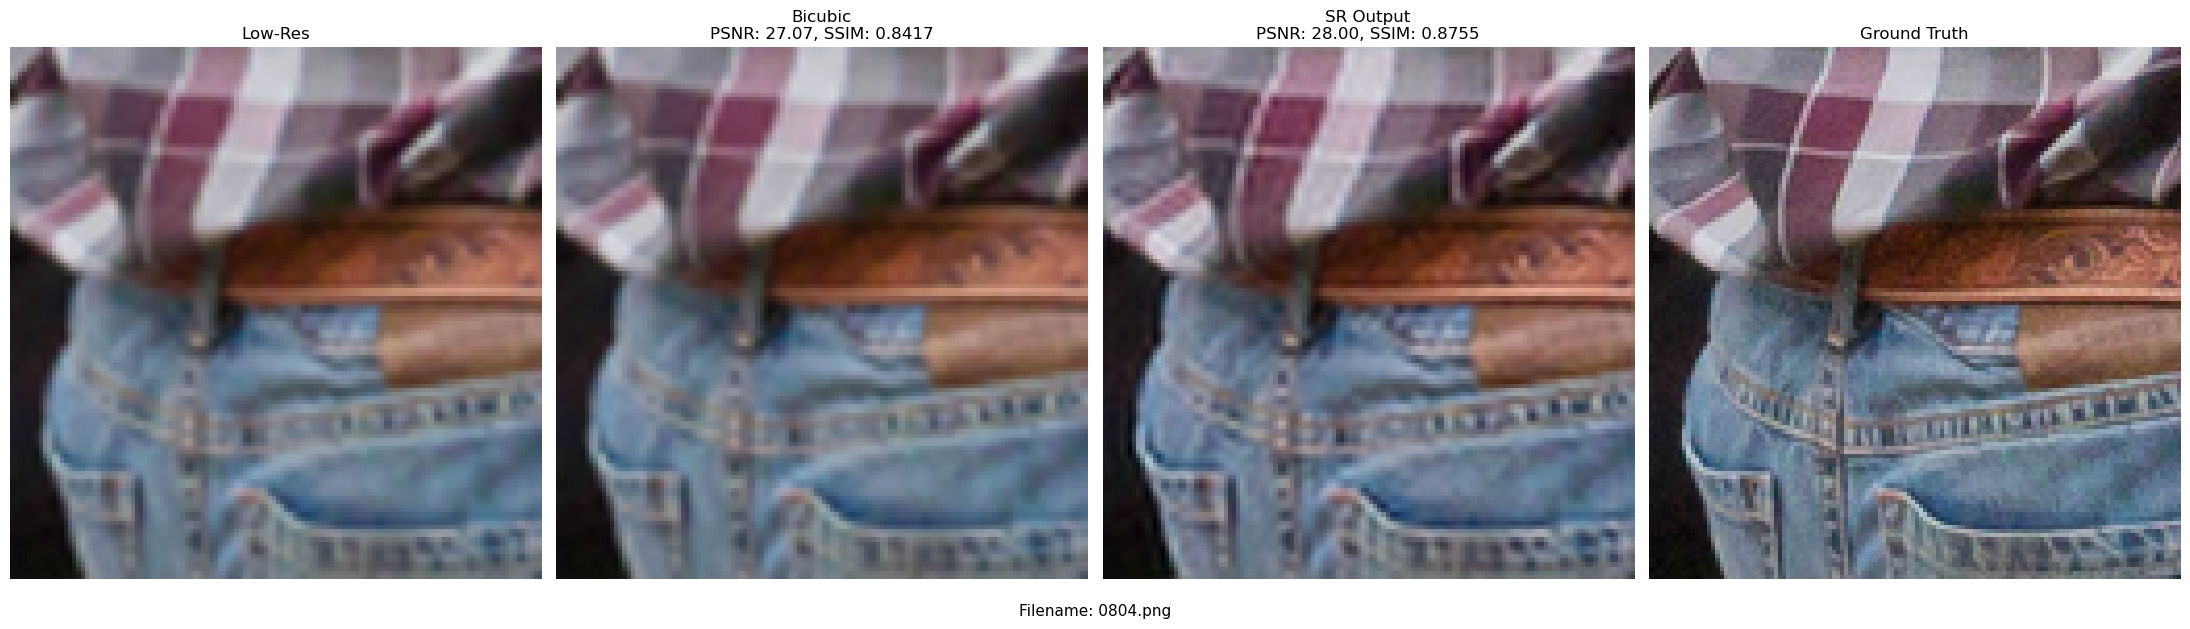

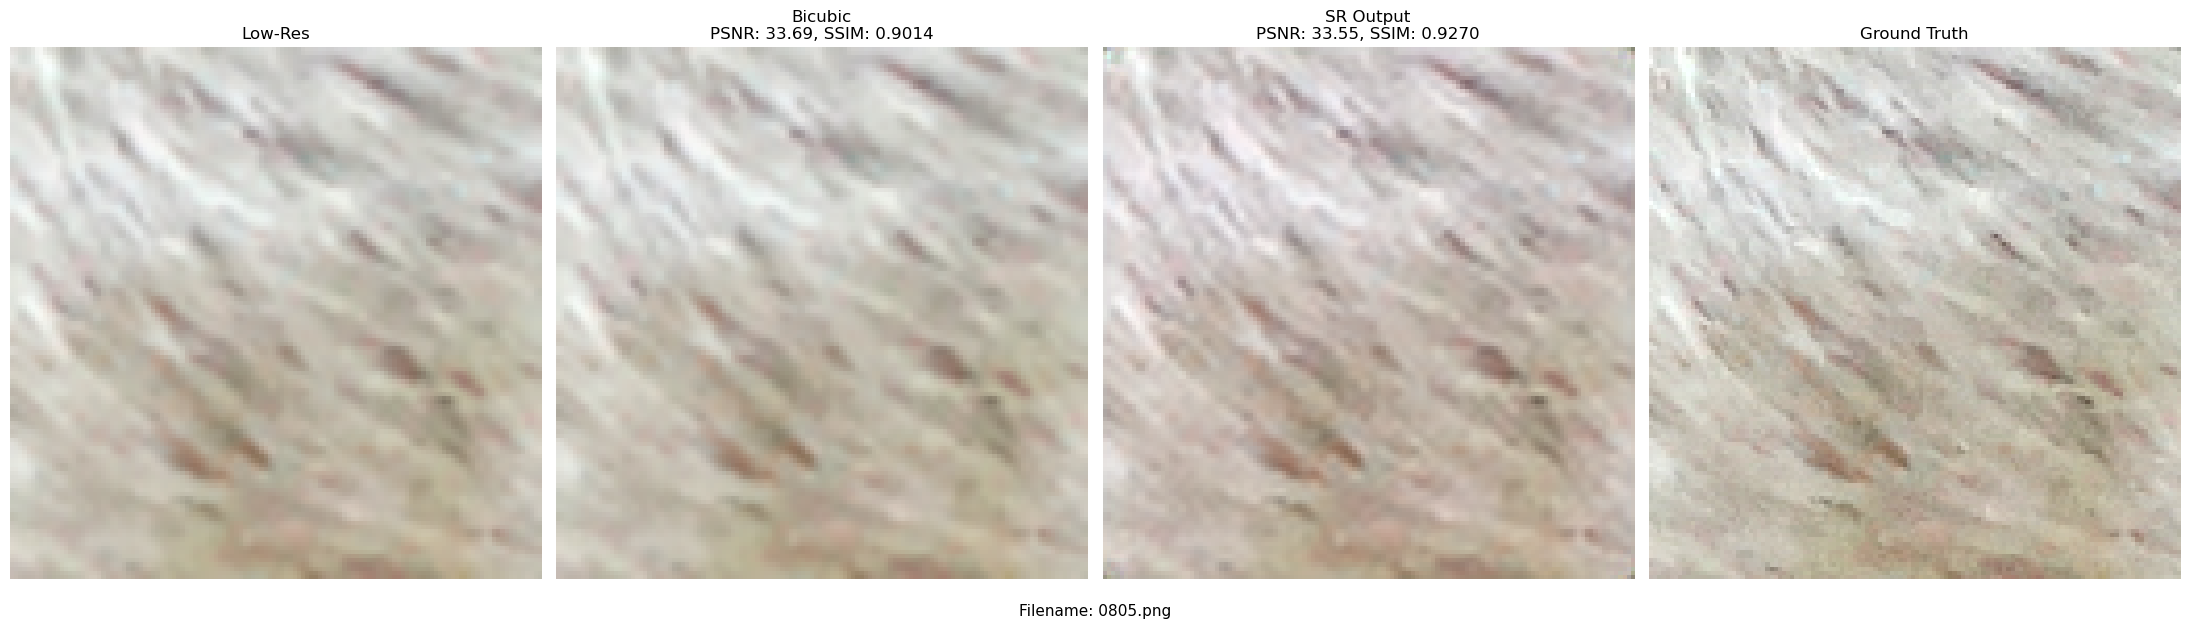

In [30]:
super_resolution_visualization(model_instance=model, dataset_sample=validation_dataset, num_images=5)


#References 

1.https://pmc.ncbi.nlm.nih.gov/articles/PMC6113156/#:~:text=Super%2DResolution%20Convolutional%20Neural%20Network,-Figure%201%20shows&text=The%20SRCNN%20scheme%20requires%20bicubic,%2Dlinear%20mapping%2C%20and%20reconstruction.


2.https://arxiv.org/pdf/1501.00092


3.https://www.youtube.com/watch?v=UYFS0ZbbhCg


4.https://medium.com/coinmonks/review-srcnn-super-resolution-3cb3a4f67a7c


5.https://aicompetence.org/training-srcnn-from-scratch-a-practical-guide/
